In [1]:
import numpy as np
import pandas as pd
from biom import load_table
from gneiss.util import match
from tenatch.tensor_factorization import TenAls
from skbio import  OrdinationResults, stats
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr
from IPython.core.display import HTML
pd.options.mode.chained_assignment = None  # default='warn'


#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
%matplotlib inline 

def plot_pcoa(x, y, samples, md, ax, factor_, colors_map=['#1f78b4','#e31a1c']):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=np.sort(list(set(md[factor_].values)))
    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class        
        ax.scatter(samples.loc[idx, x],
           samples.loc[idx, y], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1',fontsize=15)
    ax.set_ylabel('PC2',fontsize=15)
    
    return ax

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [2]:
# import the biom table
table = load_table('data/micemeth/reference-hit.biom')
# import taxa
taxa = pd.read_table('data/micemeth/taxonomy.tsv', index_col=0)
# import the metadata
meta = pd.read_table('data/micemeth/10537_20180929-125415.txt', index_col=0)

# filter sample to min depth
def sample_filter(val, id_, md): return sum(val) > 0
def observation_filter(val, id_, md): return sum(val) > 0
table = table.filter(sample_filter, axis='sample')
table = table.filter(observation_filter, axis='observation')

# ensure index matches
table,taxa = match(table.to_dataframe(),taxa)
table,meta = match(table.T,meta)

# rename table otus
table.columns=['sOTU'+str(i) for i in range(len(table.columns))]
taxa['sequence'] = taxa.index
taxa.index = table.columns

#view table
table.head(5)


,sOTU0,sOTU1,sOTU2,sOTU3,sOTU4,sOTU5,sOTU6,sOTU7,sOTU8,sOTU9,...,sOTU4690,sOTU4691,sOTU4692,sOTU4693,sOTU4694,sOTU4695,sOTU4696,sOTU4697,sOTU4698,sOTU4699
10537.p4a11.273.mar22,1189.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p7c3.39days.meth,805.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p6e10.33days.meth,482.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p1e2.272.feb11,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p3a4.275.mar6,9017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### offspring re-arrange into a tensor


In [68]:
# offspring
meta_offspring = meta[meta.treatment_group.isin(['meth.offspring','saline.offspring'])]
meta_offspring['ID'] =[x.split('.')[-1]+'_'+x.split('.')[1][3:] for x in meta_offspring.index]

# get table and filter features 
table_offspring,meta_offspring = match(table,meta_offspring)
table_offspring = table_offspring[table_offspring.sum(axis=1)>500]
table_offspring,meta_offspring = match(table_offspring,meta_offspring)

# table by timepoint
meta_offspring_time = {k:df for k,df in meta_offspring.groupby('timepoint')}

# remove samples not present in every timepoint
dropday = {k_:[v_ for v_ in list(set(meta_offspring['ID'])-set(df_['ID']))] 
           for k_,df_ in meta_offspring_time.items()}
meta_offspring = meta_offspring[~meta_offspring.timepoint.isin([k for k,v in dropday.items() if len(v)!=0])]

#final match
table_offspring = table_offspring.T[table_offspring.sum()>10].T
table_offspring,meta_offspring = match(table_offspring,meta_offspring)
table_offspring.shape


(120, 875)

In [69]:
# table by timepoint
meta_offspring_time = {k:df for k,df in meta_offspring.groupby('timepoint')}
# create tensor
tensor_offspring = []
for timepoint in sorted(meta_offspring_time.keys()):
    table_tmp,meta_tmp = match(table_offspring,meta_offspring_time[timepoint])
    meta_tmp.set_index('ID',inplace=True,drop=True)
    table_tmp = table_tmp.T.sort_index().T
    table_tmp.index = meta_tmp.index
    table_tmp.sort_index(inplace=True)
    meta_tmp.sort_index(inplace=True)
    meta_offspring_time[timepoint] = meta_tmp
    tensor_offspring.append(table_tmp)
TOff = np.dstack(tensor_offspring).T
TOff.shape


(5, 875, 24)

In [70]:
TOff_f = np.concatenate([TOff[i,:,:].T for i in range(TOff.shape[0])],axis=0)
sumzerod = [table_tmp.columns[i] for i, x in enumerate(list(TOff_f.sum(axis=0))) if x == 0]
table_offspring = table_offspring.drop(sumzerod,axis=1)


In [71]:
# table by timepoint
meta_offspring_time = {k:df for k,df in meta_offspring.groupby('timepoint')}
# create tensor
tensor_offspring = []
for timepoint in sorted(meta_offspring_time.keys()):
    table_tmp,meta_tmp = match(table_offspring,meta_offspring_time[timepoint])
    meta_tmp.set_index('ID',inplace=True,drop=True)
    table_tmp = table_tmp.T.sort_index().T
    table_tmp.index = meta_tmp.index
    table_tmp.sort_index(inplace=True)
    meta_tmp.sort_index(inplace=True)
    meta_offspring_time[timepoint] = meta_tmp
    tensor_offspring.append(table_tmp)
TOff = np.dstack(tensor_offspring).T
TOff.shape

(5, 774, 24)

In [72]:
# flatten, transform, and reshape 
TOff_rclr = np.concatenate([TOff[i,:,:].T for i in range(TOff.shape[0])],axis=0)
TOff_rclr = rclr().fit_transform(TOff_rclr)
TOff_rclr = np.dstack([TOff_rclr[(i-1)*TOff.shape[-1]:(i)*TOff.shape[-1]] for i in range(1,TOff.shape[0]+1)])
TOff_rclr[np.isnan(TOff_rclr)] = 0 


In [73]:
%%time
L1,L2,L3,s = TenAls(rank=3).fit_transform(TOff_rclr)


CPU times: user 3.32 s, sys: 470 ms, total: 3.79 s
Wall time: 3.28 s


In [74]:
%%time
tnaloff = TenAls(rank=3).fit(TOff_rclr)


CPU times: user 3.31 s, sys: 468 ms, total: 3.78 s
Wall time: 3.25 s


### visualize ordination 

In [75]:
# make df
offtime_ordin = pd.DataFrame(tnaloff.time_loading,sorted(meta_offspring_time.keys()),columns=['PC1','PC2','PC3'])
offfeature_ordin = pd.DataFrame(tnaloff.feature_loading,table_offspring.columns,columns=['PC1','PC2','PC3'])
offsample_ordin = pd.DataFrame(tnaloff.sample_loading,table_tmp.index,columns=['PC1','PC2','PC3'])



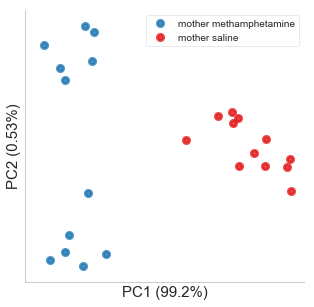

In [76]:
fig,ax = plt.subplots(1,1,figsize=(5,5))


_ = plot_pcoa('PC1', 'PC2', offsample_ordin, meta_tmp, ax, 'treated')
ax.set_xlabel('PC1 ('+str(tnaloff.explained_variance_ratio[0]*100)[:4]+'%)',fontsize=15)
ax.set_ylabel('PC2 ('+str(tnaloff.explained_variance_ratio[1]*100)[:4]+'%)',fontsize=15)

plt.legend()
plt.show()


In [77]:
# ordination emperor

time_loading = pd.DataFrame(tnaloff.time_loading,sorted(meta_offspring_time.keys()),columns=['PC1','PC2','PC3'])
feature_loading = pd.DataFrame(tnaloff.feature_loading,table_offspring.columns,columns=['PC1','PC2','PC3'])
sample_loading = pd.DataFrame(tnaloff.sample_loading,table_tmp.index,columns=['PC1','PC2','PC3'])
taxa_off = taxa.T[feature_loading.index].T.set_index('sequence')
sample_loading.index.name = None
feature_loading.index.name = None
taxa_off.index.name = 'Feature ID'

feature_loading.index = taxa_off.index 
eigvals = pd.Series(tnaloff.eigenvalues,
                        index=sample_loading.columns)
proportion_explained = pd.Series(tnaloff.explained_variance_ratio,
                                 index=sample_loading.columns)

# save ordination results 
ord_res = OrdinationResults(
        'PCoA', 
        'Principal Coordinate Analysis',
        eigvals.copy(),
        sample_loading.copy(),
        features=feature_loading.copy(),
        proportion_explained=proportion_explained.copy())
# write files to output folder
meta_tmp.to_csv('data/micemeth/offspring_map.tsv',sep='\t')
taxa_off.to_csv('data/micemeth/offspring_taxonomy.tsv',sep='\t')
ord_res.write('data/micemeth/rena_offspring_tenatch.txt')


'data/micemeth/rena_offspring_tenatch.txt'

In [40]:
!qiime tools import \
  --input-path data/micemeth/rena_offspring_tenatch.txt \
  --type 'PCoAResults % Properties("biplot")' \
  --output-path data/micemeth/rena_offspring_tenatch.qza

Imported data/micemeth/rena_offspring_tenatch.txt as OrdinationDirectoryFormat to data/micemeth/rena_offspring_tenatch.qza


In [41]:
!qiime tools import \
  --input-path data/micemeth/offspring_taxonomy.tsv \
  --type 'FeatureData[Taxonomy]' \
  --output-path data/micemeth/offspring_taxonomy.qza

Imported data/micemeth/offspring_taxonomy.tsv as TSVTaxonomyDirectoryFormat to data/micemeth/offspring_taxonomy.qza


In [44]:
!qiime emperor biplot \
    --i-biplot data/micemeth/rena_offspring_tenatch.qza \
    --m-sample-metadata-file data/micemeth/offspring_map.tsv \
    --m-feature-metadata-file  data/micemeth/offspring_taxonomy.qza \
    --o-visualization data/micemeth/offspring_biplot.qzv \
    --p-number-of-features 20


Saved Visualization to: data/micemeth/offspring_biplot.qzv


### log-ratio in time

In [355]:
numerator = offfeature_ordin.sort_values('PC1').index[0]
# get abudnant microbe across all time 
tabledenom,_ = match(table,lrmetaoff)
denom = tabledenom.mean(axis=0).sort_values(ascending=False).index[2]
denom_opp = offfeature_ordin.sort_values('PC1').index[-3]

In [356]:
# offspring
lrmetaoff = meta[meta.treatment_group.isin(['meth.offspring','saline.offspring'])]
lrmetaoff_time = {t_:match(table,tdf_) for t_,tdf_ in lrmetaoff.groupby('timepoint')}
lrmetaoff_timedf = []
for t_,tdfs_ in lrmetaoff_time.items():
    ratiodf = pd.DataFrame([np.array(np.log(tdfs_[0].loc[:,numerator]+1) - np.log(tdfs_[0].loc[:,denom]+1)).flatten(),
                            np.array(np.log(tdfs_[0].loc[:,numerator]+1) - np.log(tdfs_[0].loc[:,denom_opp]+1)).flatten(),
                            np.array(tdfs_[1]['treatment_group'].values)]).T
    ratiodf.index = tdfs_[1].index
    ratiodf.columns = ['Ratio_Core','Ratio_Opposite','Treatment']
    ratiodf['time'] = t_.split(' ')[0]
    lrmetaoff_timedf.append(ratiodf)
lrmetaoff_timedf = pd.concat(lrmetaoff_timedf,axis=0)
lrmetaoff_timedf = lrmetaoff_timedf.convert_objects(convert_numeric=True)
maptrat = {'meth.offspring':'Offspring of Meth Treated Mother', 'saline.offspring':'Offspring of Saline Treated Mother'}
lrmetaoff_timedf['Treatment'] = [maptrat[x] for x in lrmetaoff_timedf.Treatment]
 

/anaconda3/envs/qiime2-2018.11/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


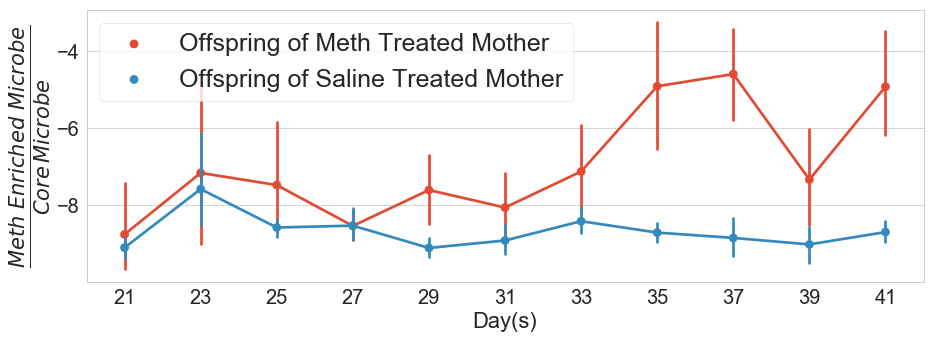

In [374]:
fig,axn = plt.subplots(1,1,figsize=(15,5))
axn = sns.pointplot(x="time", y="Ratio_Core", hue="Treatment", 
              data=lrmetaoff_timedf,ci=95)
axn.set_ylabel('$\\frac{Meth\,\,Enriched\,\,Microbe}{Core\,Microbe}$',fontsize=30)
axn.set_xlabel('Day(s)',fontsize=22)
axn.legend(loc=2, prop={'size': 25})
fig.savefig('figures/mmouse/lr_core.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()



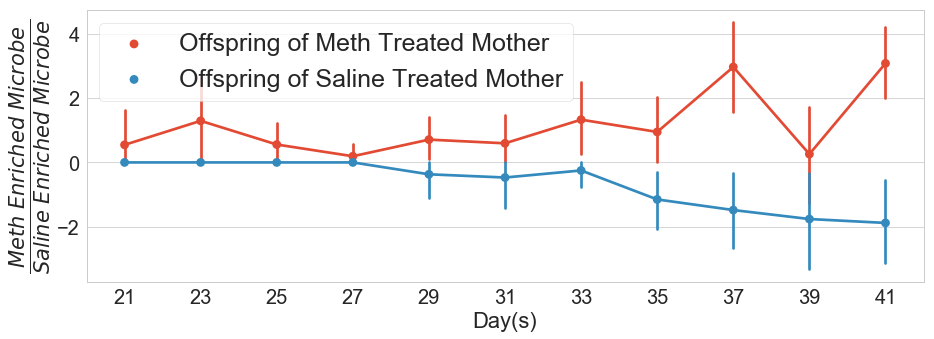

In [375]:
fig,axn = plt.subplots(1,1,figsize=(15,5))
axn = sns.pointplot(x="time", y="Ratio_Opposite", hue="Treatment", 
              data=lrmetaoff_timedf,ci=95)
axn.set_ylabel('$\\frac{Meth\,\,Enriched\,\,Microbe}{Saline\,\,Enriched\,\,Microbe}$',fontsize=30)
axn.set_xlabel('Day(s)',fontsize=22)
axn.legend(loc=2, prop={'size': 25})
fig.savefig('figures/mmouse/lr_opp.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()


### mother re-arrange into a tensor


In [46]:
# mothers
meta_mother = meta[meta.treatment_group.isin(['meth.mother','saline.mother'])]
meta_mother['ID'] =[x.split('.')[1][3:] for x in meta_mother.index]

# get table and filter features 
table_mother,meta_mother = match(table,meta_mother)
table_mother = table_mother[table_mother.sum(axis=1)>1000]
table_mother,meta_mother = match(table_mother,meta_mother)

# table by timepoint
meta_mother_time = {k:df for k,df in meta_mother.groupby('timepoint')}

# remove samples not present in every timepoint
dropday = {k_:[v_ for v_ in list(set(meta_mother['ID'])-set(df_['ID']))] 
           for k_,df_ in meta_mother_time.items()}
meta_mother = meta_mother[~meta_mother.timepoint.isin([k for k,v in dropday.items() if len(v)!=0])]

#final match
table_mother = table_mother.T[table_mother.sum()>10].T
table_mother,meta_mother = match(table_mother,meta_mother)
table_mother.shape

(216, 1048)

In [47]:
#time points left (12-samples)
len(table_mother.index)//len(set(meta_mother.ID))

18

In [48]:
# table by timepoint
meta_mother_time = {k:df for k,df in meta_mother.groupby('timepoint')}
# create tensor
tensor_mother = []
tensor_mother_ch = {}
for timepoint in sorted(meta_mother_time.keys()):
    table_tmp,meta_tmp = match(table_mother,meta_mother_time[timepoint])
    meta_tmp.set_index('ID',inplace=True,drop=True)
    table_tmp = table_tmp.T.sort_index().T
    table_tmp.index = meta_tmp.index
    table_tmp.sort_index(inplace=True)
    meta_tmp.sort_index(inplace=True)
    meta_mother_time[timepoint] = meta_tmp
    tensor_mother.append(table_tmp)
    tensor_mother_ch[timepoint] = table_tmp.shape
TMom = np.dstack(tensor_mother).T
TMom.shape


(18, 1048, 12)

In [49]:
TMom_f = np.concatenate([TMom[i,:,:].T for i in range(TMom.shape[0])],axis=0)
sumzerod = [table_tmp.columns[i] for i, x in enumerate(list(TMom_f.sum(axis=0))) if x == 0]
table_mother = table_mother.drop(sumzerod,axis=1)


In [50]:
# table by timepoint
meta_mother_time = {k:df for k,df in meta_mother.groupby('timepoint')}
# create tensor
tensor_mother = []
for timepoint in sorted(meta_mother_time.keys()):
    table_tmp,meta_tmp = match(table_mother,meta_mother_time[timepoint])
    meta_tmp.set_index('ID',inplace=True,drop=True)
    table_tmp = table_tmp.T.sort_index().T
    table_tmp.index = meta_tmp.index
    table_tmp.sort_index(inplace=True)
    meta_tmp.sort_index(inplace=True)
    meta_mother_time[timepoint] = meta_tmp
    tensor_mother.append(table_tmp)
TMom = np.dstack(tensor_mother).T
TMom.shape


(18, 905, 12)

In [51]:
TMom_f = np.concatenate([TMom[i,:,:].T for i in range(TMom.shape[0])],axis=0)
[table_tmp.columns[i] for i, x in enumerate(list(TMom_f.sum(axis=0))) if x == 0]

[]

In [52]:
# flatten, transform, and reshape 
TMom_rclr = np.concatenate([TMom[i,:,:].T for i in range(TMom.shape[0])],axis=0)
TMom_rclr = rclr().fit_transform(TMom_rclr)
TMom_rclr = np.dstack([TMom_rclr[(i-1)*TMom.shape[-1]:(i)*TMom.shape[-1]] for i in range(1,TMom.shape[0]+1)])
TMom_rclr[np.isnan(TMom_rclr)] = 0 


In [53]:
%%time
tnalmom = TenAls(rank=3).fit(TMom_rclr)


CPU times: user 9.34 s, sys: 50.2 ms, total: 9.39 s
Wall time: 9.39 s


In [54]:
# make df
momtime_ordin = pd.DataFrame(tnalmom.time_loading,sorted(meta_mother_time.keys()),columns=['PC1','PC2','PC3'])
momeature_ordin = pd.DataFrame(tnalmom.feature_loading,table_mother.columns,columns=['PC1','PC2','PC3'])
momsample_ordin = pd.DataFrame(tnalmom.sample_loading,table_tmp.index,columns=['PC1','PC2','PC3'])


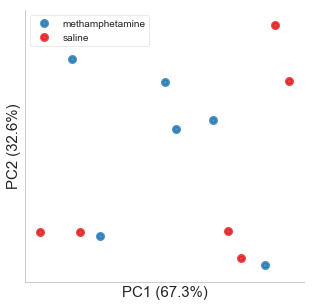

In [55]:
fig,ax = plt.subplots(1,1,figsize=(5,5))


_ = plot_pcoa('PC1', 'PC2', momsample_ordin, meta_tmp, ax, 'treated')
ax.set_xlabel('PC1 ('+str(tnalmom.explained_variance_ratio[0]*100)[:4]+'%)',fontsize=15)
ax.set_ylabel('PC2 ('+str(tnalmom.explained_variance_ratio[1]*100)[:4]+'%)',fontsize=15)

plt.legend()
plt.show()


In [56]:
# ordination emperor

time_loading = pd.DataFrame(tnalmom.time_loading,sorted(meta_mother_time.keys()),columns=['PC1','PC2','PC3'])
feature_loading = pd.DataFrame(tnalmom.feature_loading,table_mother.columns,columns=['PC1','PC2','PC3'])
sample_loading = pd.DataFrame(tnalmom.sample_loading,table_tmp.index,columns=['PC1','PC2','PC3'])
taxa_mom = taxa.T[feature_loading.index].T.set_index('sequence')
sample_loading.index.name = None
feature_loading.index.name = None
taxa_mom.index.name = 'Feature ID'

feature_loading.index = taxa_mom.index 
eigvals = pd.Series(tnalmom.eigenvalues,
                        index=sample_loading.columns)
proportion_explained = pd.Series(tnalmom.explained_variance_ratio,
                                 index=sample_loading.columns)

# save ordination results 
ord_mom = OrdinationResults(
        'PCoA', 
        'Principal Coordinate Analysis',
        eigvals.copy(),
        sample_loading.copy(),
        features=feature_loading.copy(),
        proportion_explained=proportion_explained.copy())
# write files to output folder
meta_tmp.to_csv('data/micemeth/mother_map.tsv',sep='\t')
taxa_mom.to_csv('data/micemeth/mother_taxonomy.tsv',sep='\t')
ord_mom.write('data/micemeth/rena_mother_tenatch.txt')



'data/micemeth/rena_mother_tenatch.txt'

In [57]:
!qiime tools import \
  --input-path data/micemeth/rena_mother_tenatch.txt \
  --type 'PCoAResults % Properties("biplot")' \
  --output-path data/micemeth/rena_mother_tenatch.qza


Imported data/micemeth/rena_mother_tenatch.txt as OrdinationDirectoryFormat to data/micemeth/rena_mother_tenatch.qza


In [58]:
!qiime tools import \
  --input-path data/micemeth/mother_taxonomy.tsv \
  --type 'FeatureData[Taxonomy]' \
  --output-path data/micemeth/mother_taxonomy.qza


Imported data/micemeth/mother_taxonomy.tsv as TSVTaxonomyDirectoryFormat to data/micemeth/mother_taxonomy.qza


In [59]:
!qiime emperor biplot \
    --i-biplot data/micemeth/rena_mother_tenatch.qza \
    --m-sample-metadata-file data/micemeth/mother_map.tsv \
    --m-feature-metadata-file  data/micemeth/mother_taxonomy.qza \
    --o-visualization data/micemeth/mothers_biplot.qzv \
    --p-number-of-features 20


Saved Visualization to: data/micemeth/mothers_biplot.qzv
